# Unsupervised Monocular Depth Estimation

- Jim Wu, jim.wu@uwaterloo.ca
- Dhrumil Patel, d396pate@uwaterloo.ca

# Abstract

Unsupervised Monocular Depth Estimation is a very important task in Computer Vision. At inference time, the goal is to be able to accurately estimate depth of a single image without given any labels or a correpsonding image in a stereo pair.

We walk through some theoretical motivation, conceptual ideas, and train neural networks to approach this task.

We follow in the steps of [Unsupervised Monocular Depth Estimation with Left-Right Consistency](https://arxiv.org/pdf/1609.03677.pdf) (Godard, Aodha, Brostow) and extend the approach towards more accurate depth estimation with semantic understanding of scenes. We implement the approach outlined in (Godard, Aodha, Brostow)'s work, which exploits stereo correspondence to estimate depth maps. Specifically, it exploits *smoothness, reconstructed, left-right disparity consistency* to generate disparity maps (inverse, scaled depth maps).

The second neural network we train combines the first one with segmantic information, which is inspired by research at Toyota ([here](https://medium.com/toyotaresearch/monocular-depth-in-the-real-world-99c2b287df34), [here](https://medium.com/toyotaresearch/self-supervised-learning-in-depth-part-1-of-2-74825baaaa04) and [here](https://medium.com/toyotaresearch/self-supervised-learning-in-depth-part-2-of-2-93a42ce6586f)). The segmantic network is pre-trained, so we do not need joint supervision on images for both the tasks; we only require information that is already used in the first neural network.



# Team Members and Contributions

Jim Wu, jim.wu@uwaterloo.ca
- Abstract, Ideas behind Unsupervised Monocular Depth Estimation, Conclusions
- Depth Estimator model code + architecture
- Depth Estimator with Semantic Segmentation model code + architecture
- Loss function code
- Learning Rate Scheduler

Dhrumil Patel, d396pate@uwaterloo.ca
- Abstract, Conclusions
- Data Wrangling + Transforms
- Depth Estimator model code + architecture
- Learning Rate analysis
- Loss function code
- Loss function analysis

## Ideas behind Unsupervised Monocular Depth Estimation

As previously stated, the goal is to be able to predict depth information of a single image without any extra information or data at inference time. To reach there however, we do use a bit more data. Specifically, the datasets used for training are stereo pairs, like in Assignment 3. There is no additional labelling, which is why this method is unsupervised.

During training, given a stereo pair, we estimate both a right and left disparity map, and then use those to estimate the left and right images respectively. We could use just the left image to estimate the right and left disparity maps, but using the right image in training as well enables more consistency.

Since solely stereo pairs are much easier to collect than having labelled depth data for each image (e.g. would need sensors or otherwise manually measure each pixel, and quite prone to physical effects such as environments with a lot of reflections), the unsupervised training method makes the problem much more tractable to solve well with neural networks, where we have seen espeically in the past 5 years that data is very important in acheiving high performance in deep learning. Furthermore, it allows for better depth estimation with less hardware, e.g. only using a camera instead of having LIDAR sensors for detecting depth in a mass-produced setting drastically lowers the price of the product, and thus increasing the accessibility.

### Code Libraries

We rely on many "standard" libaries that are used in the CS484 course.

PyTorch, which is used through `torch` and `torchvision`, along with some of their subpackages, are the main heavy lifters in our project. It is used for creating and training our models, including doing tensor manipulations, providing interfaces to standard datasets we train and evaluate on, dataloaders, image transforms, and performing computations on accelerators such as a GPU.

`numpy` is used for tensor manipulation and sometimes acts as an in-between layer between PyTorch and libraries like `PIL` and `matplotlib`.

`PIL` is a library used for interacting with standard image formats.
`matplotlib` is used for a variety of plots, such as displaying images from the datasets and depth images.

We also rely on a few other libraries.

`pandas` and `seaborn` (installation instructions found at https://pandas.pydata.org/docs/getting_started/install.html and https://seaborn.pydata.org/installing.html) is used for storing data about loss graphs and plotting then respectively. These could be done with `numpy` and `matplotlib` but we found that their interfaces are very easy to use and have nice display by default.

We start by importing some libraries that are cruical to the notebook from `torch` and `numpy`.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF
import torchvision.models as models
import numpy as np

Here, we can set whether or not we'd like to use an accelerator. The standard accelerator used is a GPU, but we also offer the option of automatically selecting a Mac Apple Silicon GPU is that is what is available, mainly for testing purposes.

On Google Colaboratory, the GPU that is offered is a Nvidia T4 GPU, which has 16GB of HBM memory.

In [2]:
USE_GPU = False

device_str = 'cpu'
if torch.cuda.is_available():
    USE_GPU = True
    device_str = 'cuda'
elif torch.backends.mps.is_available():
    USE_GPU = True
    device_str = 'mps'

device_str = torch.device(device_str)
print(f'Device is {device_str}')

Device is cuda


# Data Wrangling and Transformations

We use the KITTI dataset, which is a standard dataset used for training and evaluation in Monocular depth estimation. Here, we download the dataset, and then we implement methods that perform data augmentation and create dataloaders.

We implement the data augmentations outlined in Godard, Aodha and Brostow, which are:

- A resize to standardize images to 512 x 256
- Random horizontal/vertical flip
- Gamma, brightness and colour augmentation

To implement the gamma, brightness and colour augmentations, we multiply (or exponentiate for gamma augmentation) the brightness by a random value in specified ranges, pursuant to Godard, Aodha and Brostow.

- Gamma: [0.8, 1.2]
- Brightness: [0.5, 2.0]
- Colour: [0.8, 1.2]

We also implement single image dataset and dataloaders for testing.






In [3]:
%%capture
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_scene_flow.zip -O data_scene_flow.zip
!unzip data_scene_flow.zip
!mkdir datasets
!mkdir datasets/Kitti2015
!mv testing datasets/Kitti2015
!mv training datasets/Kitti2015/

<ipython-input-4-5bc6ffee62ca>:142: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  ax[0].imshow(b['left'][0].T.transpose(0, 1).int())


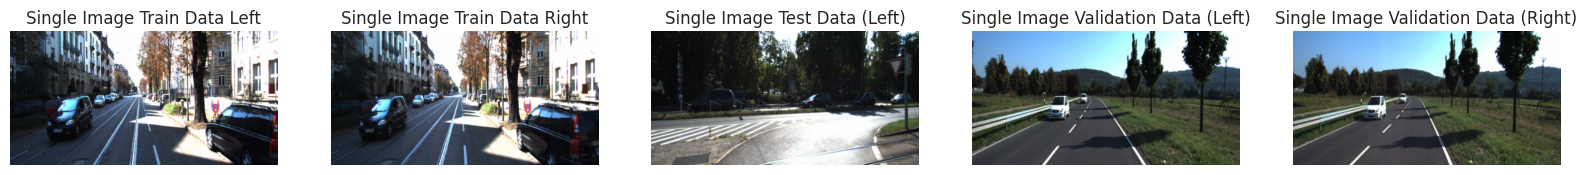

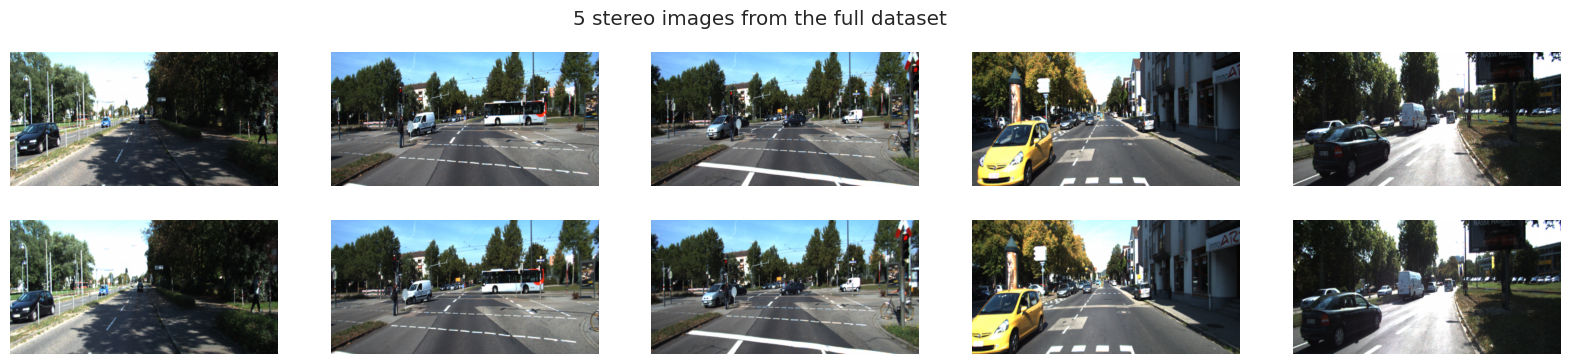

In [4]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from typing import Tuple, Callable
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


# from the assignment
class RandomFlip:
    def __init__(self, p = 0.5):
        self.p = p
    
    def __call__(self, *imgs):
        lis = list(imgs)
        if torch.rand(1) < self.p:
            for i in range(len(imgs)):
              lis[i] = tF.hflip(imgs[i])
        if torch.rand(1) < self.p:
          for i in range(len(imgs)):
              lis[i] = tF.vflip(imgs[i])
        return lis

class AugmentImagePair:
  def __init__(self):
    self.gamma_range = [0.8, 1.2]
    self.brightness_range = [0.5, 2.0]
    self.colour_range = [0.8, 1.2]
  
  def __call__(self, left, right):
    p = torch.rand(1)
    if p > 0.5:
      random_gamma = torch.rand(1) * (self.gamma_range[1] - self.gamma_range[0]) + self.gamma_range[0]
      random_brightness = torch.rand(1) * (self.brightness_range[1] - self.brightness_range[0]) + self.brightness_range[0]
      random_colours = torch.rand((3, 1, 1)) * (self.colour_range[1] - self.colour_range[0]) + self.colour_range[0]
      
      left = left ** random_gamma
      right = right ** random_gamma

      left *= random_brightness
      right *= random_brightness

      left[0] *= random_colours[0]
      left[1] *= random_colours[1]
      left[2] *= random_colours[2]
      
      right[0] *= random_colours[0]
      right[1] *= random_colours[1]
      right[2] *= random_colours[2]

      left = torch.clamp(left, 0, 255)
      right = torch.clamp(right, 0, 255)

    return left, right


def transform(left, right=None):
    resizer = transforms.Resize(size=(256, 512), antialias=True)
    # convert to tensor
    left = tF.pil_to_tensor(left).float()
    right_flag = not bool(right)
    if right_flag:
      right = torch.zeros_like(left)
    else:
      right = tF.pil_to_tensor(right).float()
    
    left = resizer(left)
    right = resizer(right)

    if right_flag:
      return left
    return left, right

class KittiDataset(Dataset):
  def __init__(self, root: str, split: str, transforms: Callable = None, prefix_dir: str = 'Kitti2015', single_image = False, val_ratio: float = 0.1):
    super().__init__()
    self.transform = transforms

    self.train = split == 'train'
    self.validate = split == 'validation'
    self.test = split == 'test'
    self.single_image = single_image
    prefix = 'training'
    if self.test:
      prefix='testing'
    
    left_path = os.path.join(root, prefix_dir, prefix, "image_2/")
    self.left_images = sorted([os.path.join(left_path, filename) for filename in os.listdir(left_path)])
    right_path = os.path.join(root, prefix_dir, prefix, "image_3/")
    self.right_images = sorted([os.path.join(right_path, filename) for filename in os.listdir(right_path)])
    
    val_length = int(len(self.left_images) * (1 - val_ratio))
    if self.validate:
      self.left_images = self.left_images[val_length:]
      self.right_images = self.right_images[val_length:]
    elif self.test:
      self.left_images = self.left_images[:val_length]
      self.right_images = self.right_images[:val_length]

  
  def __len__(self):
    if self.single_image:
        return 1
    return len(self.left_images)
  
  def __getitem__(self, idx):
    left = Image.open(self.left_images[idx])
    if self.train or self.validate:
      right = Image.open(self.right_images[idx])
      sample = {'left': left, 'right': right}
      if self.transform is not None:
        sample['left'], sample['right'] = self.transform(left, right)
      return sample
    if self.transform is not None:
      left = self.transform(left, self.train)
    return left

class KittiSingleImageDataset(KittiDataset):
  def __init__(self, root: str, split: str, transforms: Callable = None, prefix_dir: str = 'Kitti2015'):
    super().__init__(root, split, transforms, prefix_dir, single_image=True)


single_image = KittiSingleImageDataset(root='datasets', split='train', transforms=transform)
test_single_image = KittiSingleImageDataset(root='datasets', split='test', transforms=transform)
val_single_image = KittiSingleImageDataset(root='datasets', split='validation', transforms=transform)
single_image_loader = DataLoader(single_image, batch_size=1)
test_single_image_loader = DataLoader(test_single_image, batch_size=1)
val_single_image_loader = DataLoader(val_single_image, batch_size=1)

test_data = KittiDataset(root='datasets', split='test', transforms=transform)
train_data = KittiDataset(root='datasets', split='train', transforms=transform)
train_loader = DataLoader(train_data, batch_size=1, shuffle=True, num_workers=1)
test_loader = DataLoader(test_data, batch_size=1, num_workers=1)

total = 5

def show_single_dataset_images(train_loader, test_loader, val_loader):
  fig, ax = plt.subplots(1, 5, figsize=(20, 4))
  for b in train_loader:
    ax[0].imshow(b['left'][0].T.transpose(0, 1).int())
    ax[0].set_title('Single Image Train Data Left')
    ax[0].axis('off')
    ax[1].imshow(b['right'][0].T.transpose(0, 1).int())
    ax[1].set_title('Single Image Train Data Right')
    ax[1].axis('off')

  for b in test_loader:
    ax[2].imshow(b[0].T.transpose(0, 1).int())
    ax[2].set_title("Single Image Test Data (Left)")
    ax[2].axis('off')

  for b in val_loader:
    ax[3].imshow(b['left'][0].T.transpose(0, 1).int())
    ax[3].set_title('Single Image Validation Data (Left)')
    ax[3].axis('off')
    ax[4].imshow(b['right'][0].T.transpose(0, 1).int())
    ax[4].set_title('Single Image Validation Data (Right)')
    ax[4].axis('off')
  plt.show()
show_single_dataset_images(single_image_loader, test_single_image_loader, val_single_image_loader)

fig, ax = plt.subplots(2, total, figsize=(20, 4))
count = 0
for batch in train_loader:
  if count == total:
    break
  ax[0][count].imshow(batch['left'][0].T.transpose(0, 1).int())
  ax[1][count].imshow(batch['right'][0].T.transpose(0, 1).int())
  ax[0][count].axis('off')
  ax[1][count].axis('off')
  count += 1
fig.suptitle(f'{total} stereo images from the full dataset')
plt.show()


The KITTI dataset is of images taken from driven cars, so we can expect that the model will be biased towards urban environments.

# Let's start with stereo pairse (Godard, Aodha, Brostow, 2016)

In [Godard, Aodha, Brostow, 2016](https://arxiv.org/pdf/1609.03677.pdf), they explore the stereo correspondence problem by learning the matching function or learning the function to produce the disparity map itself. Rather than using hand-crafted matching functions like squared image differences in our stereo assignment, they either learn a new matching function or learn to produce the entire disparity map.

The model follows an encoder-decoder architecture. The encoder is similar to the ResNet50 architecture and the decoder uses 6 blocks of convolutional layers (upconvolution for upsampling, followed by convolutional layers, one of which generates the disparity maps). The upconvolution layer is implemented as a convolutional layer. 

In [5]:
from typing import Callable

class conv(nn.Module):
  def __init__(self, num_in_channels: int, num_out_channels: int, kernel_size: int, stride: int, normalize: bool = False):
    super().__init__()
    self.kernel_size = kernel_size
    self.conv = nn.Conv2d(num_in_channels, num_out_channels, kernel_size, stride)
    self.normalize = normalize
    if normalize:
      self.bn = nn.BatchNorm2d(num_out_channels)
  
  def forward(self, x: torch.Tensor, activation_fn: Callable = F.elu) -> torch.Tensor:
    pad_length = int(np.floor((self.kernel_size - 1) / 2))
    x = F.pad(x, (pad_length, pad_length, pad_length, pad_length))
    x = self.conv(x)
    x = activation_fn(x, inplace=True)
    if self.normalize:
      x = self.bn(x)
    return x

class conv_block(nn.Module):
  '''
  In the paper, layers are labeled conv_i and conv_ib
  conv_i and conv_ib share the same kernel size
  conv_i always has stride 2, conv_ib always has stride 1
  '''
  def __init__(self, num_in_channels: int, num_out_channels: int, kernel_size: int, normalize: bool = False):
    super().__init__()
    # self.conv1 = self.conv(num_in_channels, num_out_channels, kernel_size, stride=2)
    # self.conv2 = self.conv(num_out_channels, kernel_size, stride=1)
    self.conv1 = self.conv(num_in_channels, num_out_channels, kernel_size, stride=1)
    self.conv2 = self.conv(num_out_channels, kernel_size, stride=2)
    self.normalize = normalize
    if normalize:
      self.bn1 = nn.BatchNorm2d(num_out_channels)
      self.bn2 = nn.BatchNorm2d(num_out_channels)
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv1(x)
    if self.normalize:
      x = self.bn1(x)
    x = self.conv2(x)
    if self.normalize:
      x = self.bn2(x)
    return x

class pooley(nn.Module):
  def __init__(self, kernel_size: int):
    super().__init__()
    self.kernel_size = kernel_size

  def forward(self, x: torch.Tensor):
    pad_length = int(np.floor((self.kernel_size - 1) / 2))
    x = F.pad(x, (pad_length, pad_length, pad_length, pad_length))
    return F.max_pool2d(x, self.kernel_size, stride=2)

# standard resnet (rizznet) impl
class rizzconv(nn.Module):
  def __init__(self, num_in_layers: int, num_out_layers: int, stride: int, normalize: bool = False):
    super().__init__()
    self.num_in_layers = num_in_layers
    self.num_out_layers = num_out_layers
    self.stride = stride
    self.conv1 = conv(num_in_layers, num_out_layers, 1, 1)
    self.conv2 = conv(num_out_layers, num_out_layers, 3, stride)
    self.conv3 = nn.Conv2d(num_out_layers, 4 * num_out_layers, 1, 1)
    self.conv4 = nn.Conv2d(num_in_layers, 4 * num_out_layers, 1, stride)
    self.normalize = normalize
    if self.normalize:
      self.bn = nn.BatchNorm2d(4 * num_out_layers)
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x_out = self.conv1(x)
    x_out = self.conv2(x_out)
    x_out = self.conv3(x_out)
    shortcut = self.conv4(x)
    out = x_out + shortcut
    if self.normalize:
      out = self.bn(out)
    return F.elu(out, inplace=True)

def rizzblock(num_in_layers: int, num_out_layers: int, num_blocks: int, stride: int) -> nn.Sequential:
  layers = [rizzconv(num_in_layers, num_out_layers, stride)]
  for _ in range(num_blocks - 2):
    layers.append(rizzconv(4 * num_out_layers, num_out_layers, 1))
  layers.append(rizzconv(4 * num_out_layers, num_out_layers, 1))
  return nn.Sequential(*layers)

class upconv(nn.Module):
  def __init__(self, num_in_layers: int, num_out_layers: int, kernel_size: int, scale: int, normalize: bool = False):
    super().__init__()
    self.scale = scale
    self.conv = conv(num_in_layers, num_out_layers, kernel_size, 1, normalize)
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = F.interpolate(x, scale_factor = self.scale, mode='bilinear', align_corners = True)
    return self.conv(x)

class disparityMap(nn.Module):
  def __init__(self, num_in_layers: int, normalize: bool = False):
    super().__init__()
    self.num_in_layers = num_in_layers
    self.conv = nn.Conv2d(num_in_layers, 2, kernel_size=3, stride=1)
    self.normalize = normalize
    if self.normalize:
        self.bn = nn.BatchNorm2d(2)
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, x):
    x = F.pad(x, (1, 1, 1, 1))
    x = self.conv(x)
    return 0.3 * self.sigmoid(x)


class DepthEstimator(nn.Module):
  def __init__(self, num_in_layers: int, use_pretrained_rizznet_encoder: bool = False):
    super().__init__()
    
    # encoder
    self.use_pretrained_rizznet_encoder = use_pretrained_rizznet_encoder
    if use_pretrained_rizznet_encoder:
      self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
      for child in self.resnet.children():
            for param in child.parameters():
                param.requires_grad = False
      self.conv1 = self.resnet.conv1
      self.bn1 = self.resnet.bn1
      self.relu = self.resnet.relu
      self.pool = self.resnet.maxpool
      self.conv2 = self.resnet.layer1
      self.conv3 = self.resnet.layer2
      self.conv4 = self.resnet.layer3
      self.conv5 = self.resnet.layer4
    else:
      self.conv1 = conv(num_in_layers, 64, 7, 2)
      self.pool = pooley(3)
      self.conv2 = rizzblock(64, 64, 3, 2)
      self.conv3 = rizzblock(256, 128, 4, 2)
      self.conv4 = rizzblock(512, 256, 6, 2)
      self.conv5 = rizzblock(1024, 512, 3, 2)

    # decoder
    self.upconv6 = upconv(2048, 512, 3, 2, self.use_pretrained_rizznet_encoder)
    self.iconv6 = conv(1024 + 512, 512, 3, 1, self.use_pretrained_rizznet_encoder)

    self.upconv5 = upconv(512, 256, 3, 2, self.use_pretrained_rizznet_encoder)
    self.iconv5 = conv(512 + 256, 256, 3, 1, self.use_pretrained_rizznet_encoder)

    self.upconv4 = upconv(256, 128, 3, 2, self.use_pretrained_rizznet_encoder)
    self.iconv4 = conv(256 + 128, 128, 3, 1, self.use_pretrained_rizznet_encoder)
    self.disp4_layer = disparityMap(128, self.use_pretrained_rizznet_encoder)

    if self.use_pretrained_rizznet_encoder:
      self.upconv3 = upconv(128, 64, 3, 1, self.use_pretrained_rizznet_encoder)
    else:
      self.upconv3 = upconv(128, 64, 3, 2, self.use_pretrained_rizznet_encoder)
    self.iconv3 = conv(64 + 64 + 2, 64, 3, 1, self.use_pretrained_rizznet_encoder)
    self.disp3_layer = disparityMap(64, self.use_pretrained_rizznet_encoder)

    self.upconv2 = upconv(64, 32, 3, 2, self.use_pretrained_rizznet_encoder)
    self.iconv2 = conv(32 + 64 + 2, 32, 3, 1, self.use_pretrained_rizznet_encoder)
    self.disp2_layer = disparityMap(32, self.use_pretrained_rizznet_encoder)

    self.upconv1 = upconv(32, 16, 3, 2, self.use_pretrained_rizznet_encoder)
    self.iconv1 = conv(16 + 2, 16, 3, 1, self.use_pretrained_rizznet_encoder)
    self.disp1_layer = disparityMap(16, self.use_pretrained_rizznet_encoder)

    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)

  def forward(self, left: torch.Tensor) -> torch.Tensor:
    # encoder
    if self.use_pretrained_rizznet_encoder:
      conv_first = self.conv1(left)
      conv1b = self.bn1(conv_first)
      conv1b = self.relu(conv1b)
      conv1b_pool = self.pool(conv1b)
      conv2b = self.conv2(conv1b_pool)
      conv3b = self.conv3(conv2b)
      conv4b = self.conv4(conv3b)
      conv5b = self.conv5(conv4b)
    else:
      conv1b = self.conv1(left)
      conv_first = conv1b
      conv1b_pool = self.pool(conv1b)
      conv2b = self.conv2(conv1b_pool)
      conv3b = self.conv3(conv2b)
      conv4b = self.conv4(conv3b)
      conv5b = self.conv5(conv4b)

    skip1 = conv_first
    skip2 = conv1b_pool
    skip3 = conv2b
    skip4 = conv3b
    skip5 = conv4b

    # decoder
    upconv6 = self.upconv6(conv5b)
    inp = torch.cat((upconv6, skip5), 1)
    iconv6 = self.iconv6(inp)
    
    upconv5 = self.upconv5(iconv6)
    inp = torch.cat((upconv5, skip4), 1)
    iconv5 = self.iconv5(inp)
    
    upconv4 = self.upconv4(iconv5)
    inp = torch.cat((upconv4, skip3), 1)
    iconv4 = self.iconv4(inp)
    self.disp4 = self.disp4_layer(iconv4)
    if self.use_pretrained_rizznet_encoder:
      self.udisp4 = F.interpolate(self.disp4, scale_factor=1, mode='bilinear', align_corners=True)
      self.disp4 = F.interpolate(self.disp4, scale_factor=0.5, mode='bilinear', align_corners=True)
    else:
      self.udisp4 = F.interpolate(self.disp4, scale_factor=2, mode='bilinear', align_corners=True)

    upconv3 = self.upconv3(iconv4)
    inp = torch.cat((upconv3, skip2, self.udisp4), 1)
    iconv3 = self.iconv3(inp)
    self.disp3 = self.disp3_layer(iconv3)
    self.udisp3 = F.interpolate(self.disp3, scale_factor=2, mode='bilinear', align_corners=True)
    
    upconv2 = self.upconv2(iconv3)
    inp = torch.cat((upconv2, skip1, self.udisp3), 1)
    iconv2 = self.iconv2(inp)
    self.disp2 = self.disp2_layer(iconv2)
    self.udisp2 = F.interpolate(self.disp2, scale_factor=2, mode='bilinear', align_corners=True)
    
    upconv1 = self.upconv1(iconv2)
    inp = torch.cat((upconv1, self.udisp2), 1)
    iconv1 = self.iconv1(inp)
    self.disp1 = self.disp1_layer(iconv1)
    return self.disp1, self.disp2, self.disp3, self.disp4

# Loss Function

The loss function, pursuant to (Godard, Aodha, Brostow, 2016), encourages smooth disparity maps that are consistent with the left and right images of stereo pairs, even though the model is only given the left image.

There are three loss terms used to compute the total loss:

- Appearance Matching Loss
- Disparity Smoothness Loss
- Left-Right Disparity Consistency Loss

## Appearance Matching Loss

This loss combines structural dissimilarity between the reconstructed and actual images as well as the absolute value of the image difference (L1 loss). The structural dissimilarity of two images is a metric defined as $\frac{1 - SSIM(x, y)}{2}$, which measures how far the images are from perfect similarity (SSIM stands for structural similarity index measure; note that tha paper implements a simplification of the SSIM metric by using a 3x3 filter instead of a Gaussian, and we reproduce the same). The scaling of these terms in the loss is based off a parameter $0 < \alpha < 1$, and we calculate the loss as

$$\text{Loss}_{AM} = \frac{1}{N} (\alpha \frac{1-SSIM(x, y)}{2}) + (1 - \alpha) ||X - Y||)$$

where $N$ is the number of pixels in the image. Note that we use $\alpha = 0.85$ in our models.

## Disparity Smoothness Loss

As explored using the scan-line and grid-line approach, there are many solutions to reducing photometric loss. Many of these solutions do not produce smooth disparity maps, but we can encourage smooth disparity maps by adding a cost proportional to the gradient of the disparity map. To account for depth discontinuities at edges, we weight this cost using the image gradient. Let $I_dx$ and $I_dy$ be the image gradients for their corresponding directions, and $d_dx$ and $d_dy$ be the disparity gradients for their corresponding directions. Then the loss term is

$$\text{Loss}_{DS} = \frac{1}{N} (|d_{dx}|e^{-|I_dx|} + |d_{dy}|e^{-|I_dy|})$$

## Left-Right Disparity Consistency Loss

To encourage the left and right disparity maps to be consistent, we add the L1 penalty between the left disparity map and the projected right disparity map. The loss term is

$$\text{Loss}_{LR} = \frac{1}{N} |d^l - d^r_{\text{shifted}}|$$

where the right image is shifted to correspond with the predicted dispairities.

The final loss term is a weighted sum of these three terms (computed for both the left and right versions).



We find that the Appearnce Matching loss tends to have the highest magnitude by a large margin, so it contributes the most to the depth map our model produces. This also means that the Disparity Smoothness loss and the Left-Right Disparity Consistency Loss act almost as regularizers for the outputs that we produce.

In [6]:
from typing import List
import torch.nn as nn

class SSIM(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.AvgPool2d(3, 1)
        self.reflect = nn.ReflectionPad2d(1)

        self.C1 = 0.01 ** 2
        self.C2 = 0.03 ** 2

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        x = self.reflect(x)
        y = self.reflect(y)

        mu_x = self.pool(x) # no padding means VALID padding
        mu_y = self.pool(y)

        sigma_x = self.pool(x ** 2) - mu_x ** 2
        sigma_y = self.pool(y ** 2) - mu_y ** 2
        sigma_xy = self.pool(x * y) - mu_x * mu_y

        numer = (2 * mu_x * mu_y + self.C1) * (2 * sigma_xy + self.C2)
        denom = (mu_x ** 2 + mu_y ** 2 + self.C1) * (sigma_x + sigma_y + self.C2)

        return torch.clamp((1 - numer/denom) / 2, 0, 1)

def ssim(x, y):
    layer = SSIM()
    return layer(x, y)

def image_gradient(img, direction='x'):
  if direction == 'x':
    img = F.pad(img, (0, 1, 0, 0), mode='replicate')
    return img[:, :, :, :-1] - img[:, :, :, 1:]
  img = F.pad(img, (0, 0, 0, 1), mode='replicate')
  return img[:, :, :-1, :] - img[:, :, 1:, :]

def am_loss(x: torch.Tensor, y: torch.Tensor, alpha = 0.85) -> float:
    ssim_loss = torch.mean(ssim(x, y))
    l1_loss = torch.mean(torch.abs(x - y))

    total_loss = alpha * ssim_loss + (1 - alpha) * l1_loss
    return total_loss

def disp_smooth_loss(disparity_maps: torch.Tensor, scaled_imgs: List[torch.Tensor]) -> float:
  disparity_gradient_x = [image_gradient(d) for d in disparity_maps]
  disparity_gradient_y = [image_gradient(d, 'y') for d in disparity_maps]

  image_gradient_x = [image_gradient(d) for d in scaled_imgs]
  image_gradient_y = [image_gradient(d, 'y') for d in scaled_imgs]

  weights_x = [torch.exp(-torch.mean(torch.abs(g), 1, keepdim=True)) for g in image_gradient_x]
  weights_y = [torch.exp(-torch.mean(torch.abs(g), 1, keepdim=True)) for g in image_gradient_y]
  
  smoothness_x = [disparity_gradient_x[i] * weights_x[i] for i in range(4)]
  smoothness_y = [disparity_gradient_y[i] * weights_y[i] for i in range(4)]

  return [torch.abs(smoothness_x[i]) + torch.abs(smoothness_y[i]) for i in range(4)]

def apply_disparity(img, disp):
  # use the spatial transformer technique to generate images
  bs, _, height, width = img.size()

  x_coords = torch.linspace(0, 1, width).repeat(bs, height, 1).type_as(img)
  y_coords = torch.linspace(0, 1, height).repeat(bs, width, 1).transpose(1, 2).type_as(img)
  
  shifts = disp[:, 0, :, :]
  flow = torch.stack((x_coords + shifts, y_coords), dim=3)
  return F.grid_sample(img, 2 * flow - 1, mode='bilinear', padding_mode='zeros', align_corners=True)

def get_scaled_images(image, num_scales = 4):
  scaled_images = [image]
  s = image.size()
  h = s[2]
  w = s[3]
  for i in range(1, num_scales):
    hs = h // (2 ** i)
    ws = w // (2 ** i)
    scaled_images.append(F.interpolate(image, size=[hs, ws], mode='bilinear', align_corners=True))
  return scaled_images
  
def generate_image_left(scaled_image, disparity):
  return apply_disparity(scaled_image, -disparity)

def generate_image_right(scaled_image, disparity):
  return apply_disparity(scaled_image, disparity)

# for computing the loss of C_s = alpha_ap(...) + alpha_ds(...) + alpha_lr(...)
# we must set the correct pararms
# during opt, we use alpha_ap = 1 and alpha_lr = 1
# on the other hand, we use alpha_ds = 0.1/r where r is the downscaling factor

class LossyBoy(nn.Module):
  def __init__(self, output_scales: int = 4, disparity_gradient_w: float = 0.1, lr_w: float = 1):
    super().__init__()
    self.output_scales = output_scales
    self.disparity_gradient_w = disparity_gradient_w
    self.lr_w = lr_w

  def forward(self, disparity_maps: torch.Tensor, left_image: torch.Tensor, right_image: torch.Tensor) -> float:
    scaled_lefts = get_scaled_images(left_image)
    scaled_rights = get_scaled_images(right_image)

    left_disparities = [dm[:, 0, :, :].unsqueeze(1) for dm in disparity_maps]
    right_disparities = [dm[:, 1, :, :].unsqueeze(1) for dm in disparity_maps]

    reconstructed_lefts = [generate_image_left(right, disp) for right, disp in zip(scaled_rights, left_disparities)]
    reconstructed_rights = [generate_image_right(left, disp) for left, disp in zip(scaled_lefts, right_disparities)]

    right_left_disparity = [generate_image_left(right, left) for right, left in zip(right_disparities, left_disparities)]
    left_right_disparity = [generate_image_right(left, right) for right, left in zip(right_disparities, left_disparities)]

    left_smoothness = disp_smooth_loss(left_disparities, scaled_lefts)
    left_smoothness = [torch.mean(torch.abs(left_smoothness[i] / 2 ** i)) for i in range(self.output_scales)]
    
    right_smoothness = disp_smooth_loss(right_disparities, scaled_rights)
    right_smoothness = [torch.mean(torch.abs(right_smoothness[i] / 2 ** i)) for i in range(self.output_scales)]
    total_smoothness_loss = sum(left_smoothness + right_smoothness)

    left_am_loss = [am_loss(estimated, actual) for estimated, actual in zip(reconstructed_lefts, scaled_lefts)]
    right_am_loss = [am_loss(estimated, actual) for estimated, actual in zip(reconstructed_rights, scaled_rights)]
    total_am_loss = sum(left_am_loss + right_am_loss)

    lr_left_loss = [torch.mean(torch.abs(both_disp - one_disp)) for both_disp, one_disp in zip(right_left_disparity, left_disparities)]
    lr_right_loss = [torch.mean(torch.abs(both_disp - one_disp)) for both_disp, one_disp in zip(left_right_disparity, right_disparities)]
    total_lr_loss = sum(lr_left_loss + lr_right_loss)

    loss = total_am_loss + self.disparity_gradient_w * total_smoothness_loss + self.lr_w * total_lr_loss
    return loss, total_smoothness_loss, total_am_loss, total_lr_loss

# Training

There are a few key differences in the training from (Godard, Aodha, Brostow, 2016). We use the Kitti 2015 Stereo dataset, which has 400 training images. As a result, we train for more epochs and attempt to use a more aggressive learning rate schedule.

In [7]:
def validate(model: DepthEstimator, loss_manager: LossyBoy, val_loader: DataLoader) -> torch.Tensor:
  total_loss = 0
  smoothness_loss = 0
  am_loss = 0
  lr_loss = 0
  with torch.no_grad():
    for batch in val_loader:
      left = batch['left'].to(device_str)
      right = batch['right'].to(device_str)
      disparity_maps = model(left)
      loss, sm_loss, a_loss, l_loss = loss_manager(disparity_maps, left, right)
      total_loss += loss
      smoothness_loss += sm_loss
      am_loss += a_loss
      lr_loss += l_loss
  return total_loss, smoothness_loss, am_loss, lr_loss

In [32]:
# set up the optimizer, learning rates, and some other hyperparameters according to the paper
import torch.optim as optim
import tqdm
from tqdm.notebook import tqdm
from tqdm import trange
from typing import Dict
from torch.optim.lr_scheduler import SequentialLR, ConstantLR, LRScheduler, ReduceLROnPlateau, LinearLR

class CustomLR(LRScheduler):
    def __init__(self, optimizer, last_epoch=-1):
        super().__init__(optimizer, last_epoch, False)

    def get_lr(self):
        # if self.last_epoch < 40:
        #     return [self.lr]
        # else:
        #   if self.last_epoch % 10 == 0:
        #     self.lr /= 2.
        #   return [self.lr]
        if self.last_epoch < 400:
          return [2e-4]
        return [2.2e-4]
        # if self.last_epoch >= 30 and self.last_epoch < 40:
        #     return [1e-4 / 2]
        # elif self.last_epoch >= 40:
        #     return [1e-4 / 4]
        # else:
        #     return [1e-4]

def train(model: DepthEstimator, train_loader: DataLoader, val_loader: DataLoader = None, EPOCHS = 50, lr = 1e-4) -> Tuple[Dict]:
  model.train()
  optimizer = optim.Adam(model.parameters(), lr=lr) # 1e-4 = 0.0001
  # scheduler = CustomLR(optimizer)
  # scheduler = ReduceLROnPlateau(optimizer, 'min')
  # scheduler = LinearLR(optimizer, total_iters=10)
  loss_manager = LossyBoy().to(device_str)
  keys = ["total", "smoothness", "am", "lr"]
  train_losses = {key: [] for key in keys}
  val_losses = {key: [] for key in keys}

  for epoch in trange(1, EPOCHS + 1):
    epoch_loss = 0
    epoch_smoothness_loss = 0
    epoch_am_loss = 0
    epoch_lr_loss = 0

    for batch in train_loader:
    # for batch in train_loader:
      optimizer.zero_grad()
      left = batch['left'].to(device_str)
      right = batch['right'].to(device_str)
      disparity_maps = model(left)
      loss, smoothness_loss, am_loss, lr_loss = loss_manager(disparity_maps, left, right)
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      smoothness_loss = smoothness_loss.item()
      am_loss = am_loss.item()
      lr_loss = lr_loss.item()
      
      epoch_smoothness_loss += smoothness_loss
      epoch_am_loss += am_loss
      epoch_lr_loss += lr_loss
    
    epoch_loss /= len(train_loader) * train_loader.batch_size
    epoch_smoothness_loss /= len(train_loader) * train_loader.batch_size
    epoch_am_loss /= len(train_loader) * train_loader.batch_size
    epoch_lr_loss /= len(train_loader) * train_loader.batch_size
    train_losses["total"].append(epoch_loss)
    train_losses["smoothness"].append(epoch_smoothness_loss)
    train_losses["am"].append(epoch_am_loss)
    train_losses["lr"].append(epoch_lr_loss)

    if val_loader is not None:
      val_loss = validate(model, loss_manager, val_loader)
      val_loss = list(val_loss)
      
      for idx in range(len(val_loss)):
        val_loss[idx] /= len(val_loader) * val_loader.batch_size
      
      for key, loss in zip(keys, val_loss):
        val_losses[key].append(loss.item())
    # scheduler.step(val_loss)
    # scheduler.step()
  return train_losses, val_losses

In [25]:
def test(model: DepthEstimator, test_loader) -> Dict:
  model.eval()
  loss_manager = LossyBoy().to(device_str)
  disparity_maps = []
  with torch.no_grad():
    for batch in tqdm(test_loader):
      if isinstance(batch, dict):
        left = batch['left'].to(device_str)
      else:
        left = batch.to(device_str)
      disps, _, _, _ = model(left)
      disparity_maps.append(disps.detach().cpu().numpy())
  return disparity_maps

In [26]:
import pandas as pd

def plot_losses(train_losses, val_losses = None):
  loss_df = pd.DataFrame()
  for key in train_losses:
    loss_df["train_" + key] = train_losses[key]
  if val_losses is not None:
    for key in val_losses:
      loss_df["val_" + key] = val_losses[key]
  sns.lineplot(loss_df)
  plt.show()

In [27]:
import matplotlib.pyplot as plt

def display_disparity_maps(model, train_loader, test_loader):
  fig, ax = plt.subplots(2, 2, figsize=(8, 4))

  train_single_disparity = test(model, train_loader)
  test_single_disparity = test(model, test_loader)

  train_disparity = train_single_disparity[0][0, 0, :, :]
  test_disparity = test_single_disparity[0][0, 0, :, :]
  train_image = single_image[0]['left'].T.transpose(0, 1).int()
  test_image = test_single_image[0].T.transpose(0, 1).int()

  ax[1][0].imshow(train_image)
  ax[1][0].axis('off')
  ax[1][0].grid('off')
  ax[1][0].set_title("train image")
  ax[1][1].imshow(test_image)
  ax[1][1].set_title("test image")
  ax[1][1].axis('off')
  ax[1][1].grid('off')

  ax[0][0].imshow(train_disparity)
  ax[0][0].set_title("train disparity")
  ax[0][0].axis('off')
  ax[0][0].grid('off')
  ax[0][1].imshow(test_disparity)
  ax[0][1].set_title("test disparity")
  ax[0][1].axis('off')
  ax[0][1].grid('off')
  plt.show()

# Single Image Analysis

We attempt to overfit a model to a single image to develop intuition about the results we should expect.

## Prepare the Single Image Dataset

We build our dataloaders and plot the images for reference

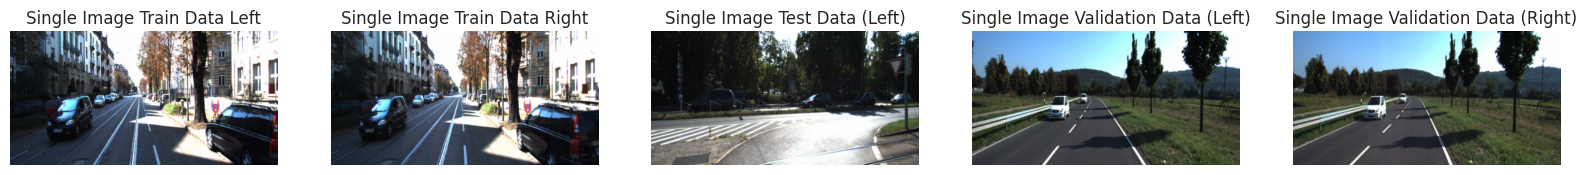

In [12]:
single_image = KittiSingleImageDataset(root='datasets', split='train', transforms=transform)
single_image_loader = DataLoader(single_image, batch_size=1)

test_single_image = KittiSingleImageDataset(root='datasets', split='test', transforms=transform)
test_single_image_loader = DataLoader(test_single_image, batch_size=1)

val_single_image = KittiSingleImageDataset(root='datasets', split='validation', transforms=transform)
val_single_image_loader = DataLoader(val_single_image, batch_size=1)
show_single_dataset_images(single_image_loader, test_single_image_loader, val_single_image_loader)

## Train a model without the pre-trained resnet encoder

We train for 1000 epochs with learning rate 1e-4

In [ ]:
EPOCHS = 1000
batch_size = 1

model = DepthEstimator(3).to(device_str)
train_losses, _ = train(model, train_loader=single_image_loader, EPOCHS=EPOCHS)

100%|██████████| 1000/1000 [02:22<00:00,  7.01it/s]


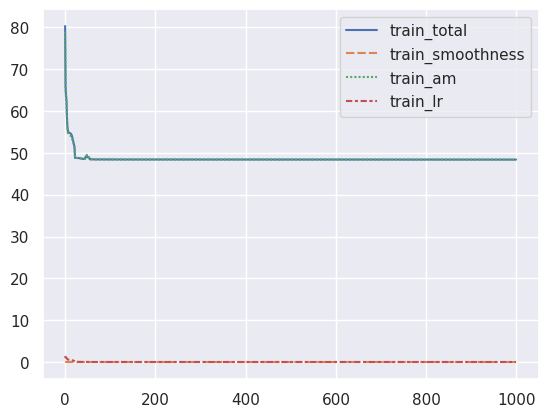

In [ ]:
plot_losses(train_losses)

It's clear that the appearance matching loss, made up of the structural similarity and L1 losses, contribute almost entirely towards the loss. This suggests that the other losses help as regularization, rather than being a significant metric to optimize.

The loss curve is not very smooth, which suggests that we may need to train for more epochs or with a larger learning rate.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

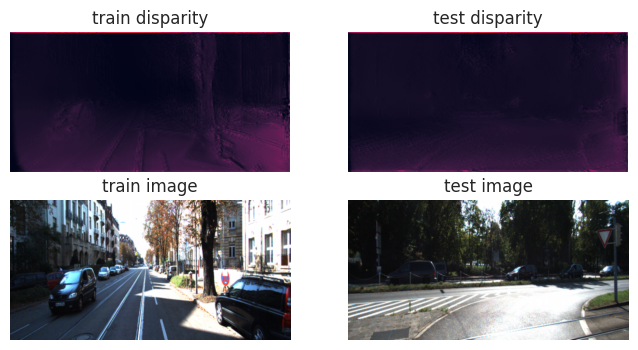

In [ ]:
display_disparity_maps(model, single_image_loader, test_single_image_loader)

The resulting depth maps are detailed, with some obvious artifacts:

- The model incorrectly predicts that the lanes are further from the camera than the surrounding pavement. We believe that this is likely only because they're painted white, which would be more reflective and thus appear as a depth discontinuity. The loss function lightly weighs drastic changes in the image (disparity smoothness loss), so the model's outputs are not strongly encouraged to be consistent for large changes in the image.

## Train a depth estimator with the pretrained resnet encoder

In [42]:
EPOCHS = 1000
batch_size = 1

model = DepthEstimator(3, use_pretrained_rizznet_encoder=True).to(device_str)
train_losses, _ = train(model, train_loader=single_image_loader, EPOCHS=EPOCHS, lr=1.1e-4)

100%|██████████| 1000/1000 [02:13<00:00,  7.51it/s]


With learning rate 1e-4

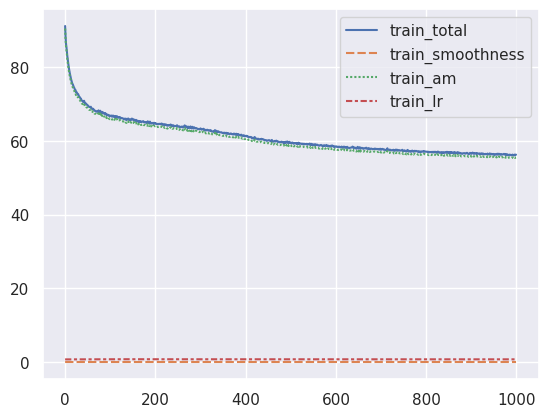

In [ ]:
plot_losses(train_losses)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

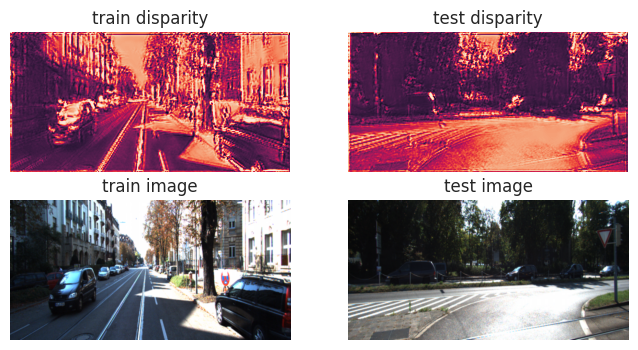

In [ ]:
display_disparity_maps(model, single_image_loader, test_single_image_loader)

Let's test several learning rates:

100%|██████████| 1000/1000 [02:24<00:00,  6.94it/s]


final loss: 50.66065979003906, lr: 0.0001


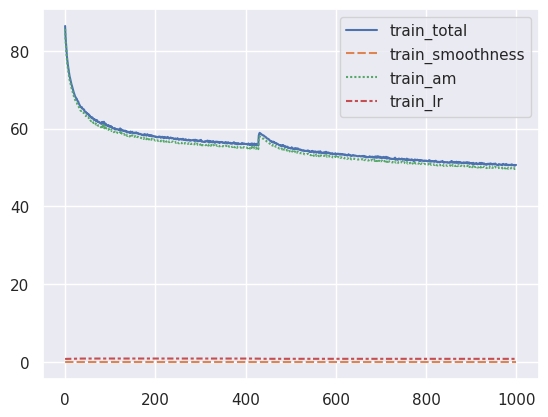

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

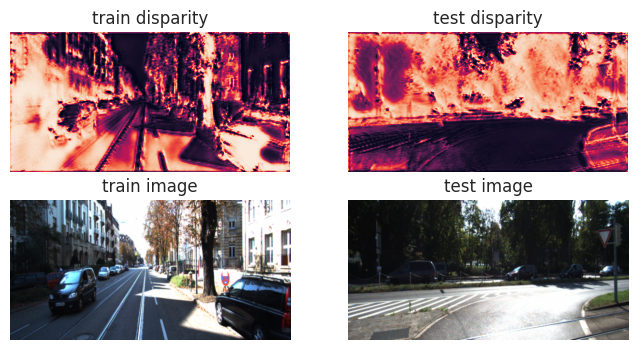

100%|██████████| 1000/1000 [02:14<00:00,  7.43it/s]


final loss: 47.766204833984375, lr: 0.0002


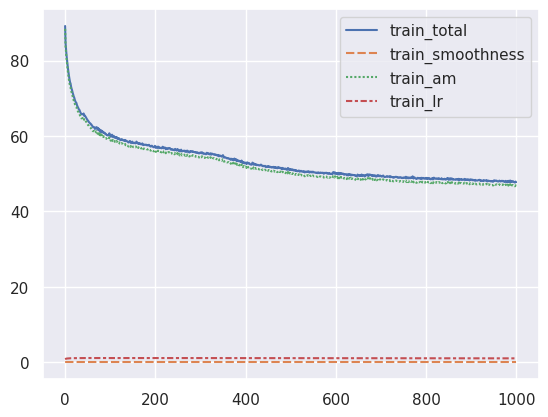

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

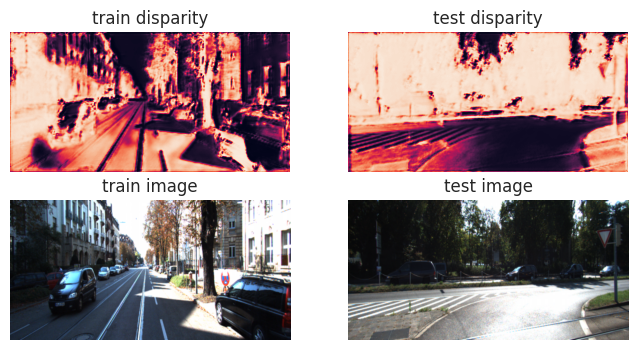

100%|██████████| 1000/1000 [02:16<00:00,  7.34it/s]


final loss: 23.235401153564453, lr: 0.0005


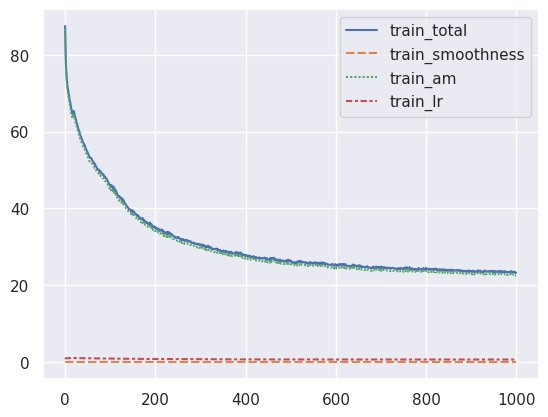

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

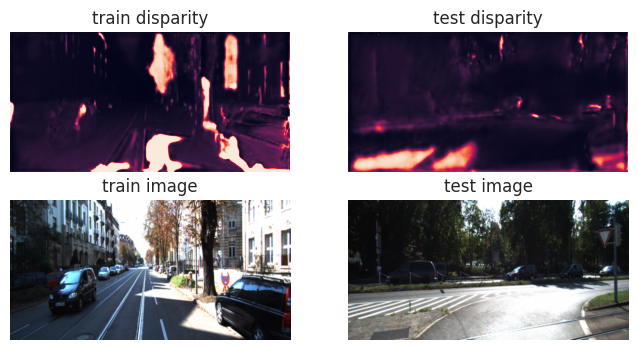

100%|██████████| 1000/1000 [02:16<00:00,  7.32it/s]


final loss: 19.255159378051758, lr: 0.001


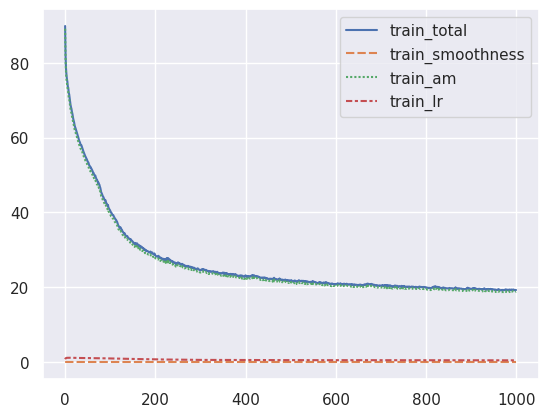

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

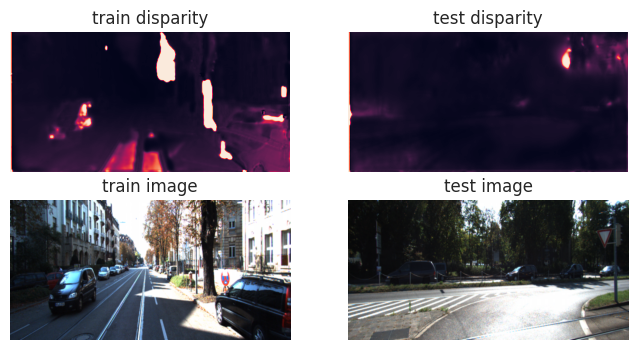

In [38]:
EPOCHS = 1000
batch_size = 1

lrs = [1e-4, 2e-4, 5e-4, 1e-3]

for lr in lrs:
  model = DepthEstimator(3, use_pretrained_rizznet_encoder=True).to(device_str)
  train_losses, _ = train(model, train_loader=single_image_loader, EPOCHS=EPOCHS, lr=lr)
  print(f"final loss: {train_losses['total'][-1]}, lr: {lr}")
  plot_losses(train_losses)
  plt.show()
  display_disparity_maps(model, single_image_loader, test_single_image_loader)
  plt.show()

We observe that, even after obtaining smaller loss using larger learning rates, it appears that the generated disparity maps decrease in quality. Thus, we choose to use a constant learning rate of 1e-4.

## Observations from single dataset analysis

We observe that using the Imagenet weights for the ResNet50 encoder drastically improves the quality of the generated disparity maps.

The loss curve with the pretrained ResNet weights also looks much smoother and suggests that training for more epochs would reduce the loss further.

However, the value of the loss function after 1000 epochs looks to be greater than or close to the loss after 1000 epochs without the pre-trained resnet encoder. This suggests that the loss function could be further tuned to encourage more detailed disparity maps.

We proceed to train a model on the entire training dataset using the pretrained ResNet encoder with ImageNet weights.

Similar to the previous model, brighter areas of pavement are predicted to be a very different depth from the surrounding, darker pavement.

# Entire dataset

In [13]:
train_data = KittiDataset(root='datasets', split='train', transforms=transform)
test_data = KittiDataset(root='datasets', split='test', transforms=transform)

batch_size = 8

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
EPOCHS = 100
model = DepthEstimator(3, use_pretrained_rizznet_encoder=True).to(device_str)
train_losses, _ = train(model, train_loader=train_loader, EPOCHS=EPOCHS)

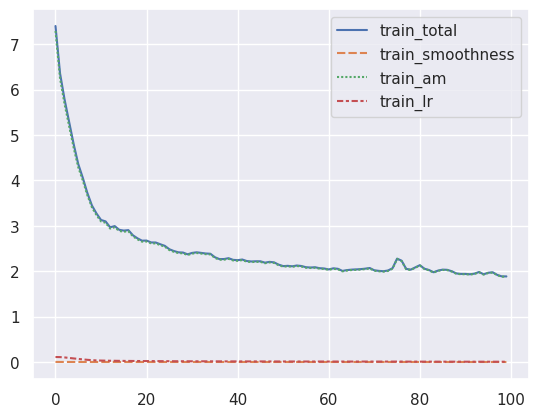

In [15]:
plot_losses(train_losses)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

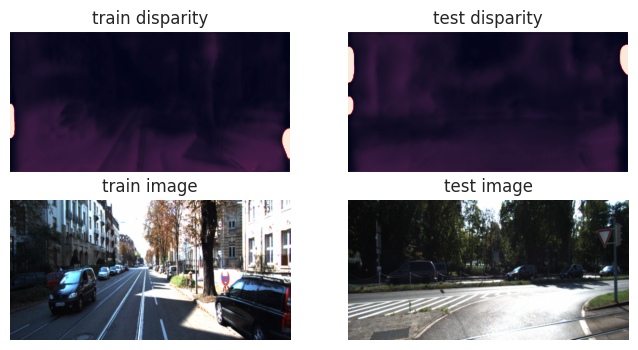

In [16]:
display_disparity_maps(model, single_image_loader, test_single_image_loader)

## Neural Network with Segmantic Information

The first neural network does decently! We are able to train a network that can predict depth based on only one image, and we trained only on stereo pairs that did not have depth information. While stereo pairs will give us geometric priors about depth immediately, we thought that it doesn't take into account more semantic information about the scene, namely the presence and location of objects within a scene. 

Due to this, we propose adding segmentation information by adding a pretrained semantic segmentation network to our stack. We hope that this will increase performance because we in some sense add a "prior" of information about objects in the scene and how they relate to each other. At some layers in the original depth estimation model we have, we concatenate activations with the activations of the semantic segmentation network. PyTorch provides easy access to a few of these models, and we decided to use the FCN network with ResNet-50 backbone provided by PyTorch, which is based off the paper [Fully Convolutional Networks for Semantic Segmentation](https://arxiv.org/abs/1411.4038).

In [18]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

class DepthEstimatorSeg(nn.Module):
    def __init__(self, num_in_layers: int):
        super().__init__()
        weights = FCN_ResNet50_Weights.DEFAULT
        self.fcn = fcn_resnet50(weights=weights)
        self.activation  = {}
        def get_activation(name):
            def hook(model, input, output):
                self.activation[name] = output.detach()
            return hook
        
        self.fcn.backbone.layer1.register_forward_hook(get_activation('layer1'))
        self.fcn.backbone.layer2.register_forward_hook(get_activation('layer2'))
        self.fcn.backbone.layer3.register_forward_hook(get_activation('layer3'))
        self.fcn.backbone.layer4.register_forward_hook(get_activation('layer4'))
    
        # encoder
        self.conv1 = conv(num_in_layers, 64, 7, 2)
        self.pool1 = pooley(3)
        self.conv2 = rizzblock(64+256, 64, 3, 2)
        self.conv3 = rizzblock(256+512+1024+2048, 128, 4, 2)
        self.conv4 = rizzblock(512, 256, 6, 2)
        self.conv5 = rizzblock(1024, 512, 3, 2)

        # decoder
        self.upconv6 = upconv(2048, 512, 3, 2)
        self.iconv6 = conv(1024 + 512, 512, 3, 1)

        self.upconv5 = upconv(512, 256, 3, 2)
        self.iconv5 = conv(512 + 256, 256, 3, 1)

        self.upconv4 = upconv(256, 128, 3, 2)
        self.iconv4 = conv(256 + 128 + 512+1024+2048, 128, 3, 1)
        self.disp4_layer = disparityMap(128)

        self.upconv3 = upconv(128, 64, 3, 2)
        self.iconv3 = conv(64 + 64 + 2 + 256, 64, 3, 1)
        self.disp3_layer = disparityMap(64)

        self.upconv2 = upconv(64, 32, 3, 2)
        self.iconv2 = conv(32 + 64 + 2, 32, 3, 1)
        self.disp2_layer = disparityMap(32)

        self.upconv1 = upconv(32, 16, 3, 2)
        self.iconv1 = conv(16 + 2, 16, 3, 1)
        self.disp1_layer = disparityMap(16)

        lis = [self.conv1, self.pool1, self.conv2, self.conv3, self.conv4,
               self.conv5, self.upconv6, self.iconv6, self.upconv5, self.iconv5,
               self.upconv4, self.iconv4, self.upconv3, self.iconv3,
               self.upconv2, self.iconv2, self.upconv1, self.iconv1,
               self.disp4_layer, self.disp3_layer, self.disp2_layer,
               self.disp1_layer]

        for l in lis:
          for m in l.modules():
              if isinstance(m, nn.Conv2d):
                  nn.init.xavier_uniform_(m.weight)

    def forward(self, left: torch.Tensor) -> torch.Tensor:
        self.fcn(left)

        # torch.Size([1, 256, 64, 128]) l1
        # torch.Size([1, 512, 32, 64]) l2
        # torch.Size([1, 1024, 32, 64]) l3 
        # torch.Size([1, 2048, 32, 64]) l4
        fcn_l1 = self.activation['layer1']
        fcn_l2 = self.activation['layer2']
        fcn_l3 = self.activation['layer3']
        fcn_l4 = self.activation['layer4']

        # encoder
        conv1b = self.conv1(left) # (b, 64, 128, 256)
        conv1b_pool = self.pool1(conv1b) # (b, 64, 64, 128)
        conv1b_pool = torch.cat((conv1b_pool, fcn_l1), dim=1)
        conv2b = self.conv2(conv1b_pool)  # (b, 256, 32, 64)
        conv2b = torch.cat((conv2b, fcn_l2, fcn_l3, fcn_l4), dim=1)
        conv3b = self.conv3(conv2b)  # (b, 512, 16, 32)
        conv4b = self.conv4(conv3b)  # (b, 1024, 8, 16)
        conv5b = self.conv5(conv4b) # (b, 2048, 4, 8)

        skip1 = conv1b
        skip2 = conv1b_pool
        skip3 = conv2b
        skip4 = conv3b
        skip5 = conv4b

        # decoder
        upconv6 = self.upconv6(conv5b) # (b, 512, 8, 16)
        inp = torch.cat((upconv6, skip5), 1) # (b, 1536, 8, 16)
        iconv6 = self.iconv6(inp) # (b, 512, 8, 16)

        upconv5 = self.upconv5(iconv6)
        inp = torch.cat((upconv5, skip4), 1)
        iconv5 = self.iconv5(inp)

        upconv4 = self.upconv4(iconv5)
        inp = torch.cat((upconv4, skip3), 1)
        iconv4 = self.iconv4(inp)
        self.disp4 = self.disp4_layer(iconv4)
        self.udisp4 = F.interpolate(self.disp4, scale_factor=2, mode='bilinear', align_corners=True)

        upconv3 = self.upconv3(iconv4)
        inp = torch.cat((upconv3, skip2, self.udisp4), 1)
        iconv3 = self.iconv3(inp)
        self.disp3 = self.disp3_layer(iconv3)
        self.udisp3 = F.interpolate(self.disp3, scale_factor=2, mode='bilinear', align_corners=True)

        upconv2 = self.upconv2(iconv3)
        inp = torch.cat((upconv2, skip1, self.udisp3), 1)
        iconv2 = self.iconv2(inp)
        self.disp2 = self.disp2_layer(iconv2)
        self.udisp2 = F.interpolate(self.disp2, scale_factor=2, mode='bilinear', align_corners=True)

        upconv1 = self.upconv1(iconv2)
        inp = torch.cat((upconv1, self.udisp2), 1)
        iconv1 = self.iconv1(inp)
        self.disp1 = self.disp1_layer(iconv1)
        return self.disp1, self.disp2, self.disp3, self.disp4
model = DepthEstimatorSeg(3).to(device_str)

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:03<00:00, 43.4MB/s]


# Single dataset Analysis

In [ ]:
EPOCHS = 100
batch_size = 1

model = DepthEstimatorSeg(3).to(device_str)
train_losses, _ = train(model, train_loader=single_image_loader, EPOCHS=EPOCHS)

100%|██████████| 100/100 [12:45<00:00,  7.65s/it]


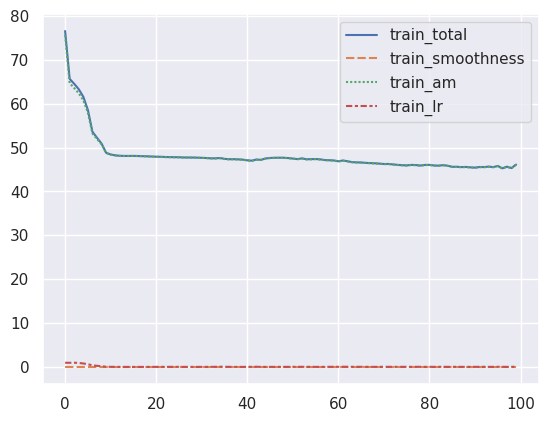

In [ ]:
plot_losses(train_losses)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

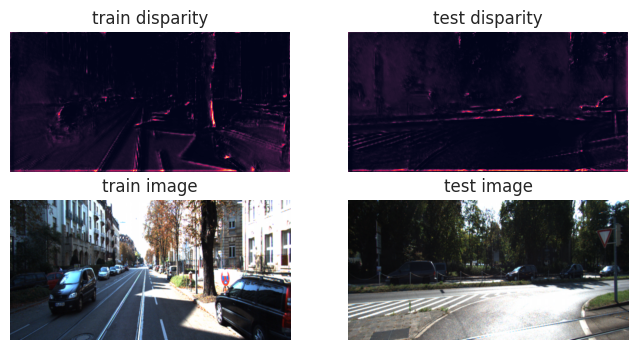

In [ ]:
display_disparity_maps(model, single_image_loader, test_single_image_loader)

# Entire Dataset Analysis

In [20]:
EPOCHS = 90

depth_estimator_seg_model = DepthEstimatorSeg(3).to(device_str)
depth_estimator_seg_train_losses, _ = train(model, train_loader=train_loader, EPOCHS=EPOCHS)

100%|██████████| 90/90 [1:21:47<00:00, 54.53s/it]


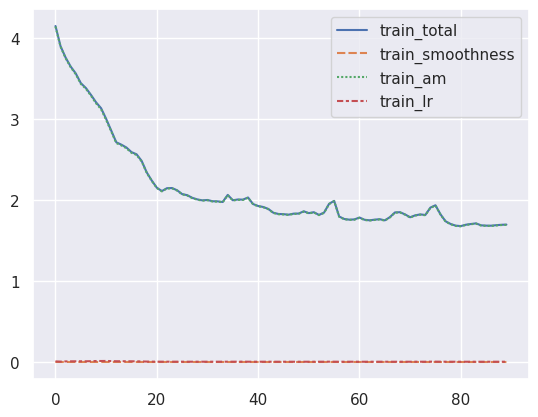

In [21]:
plot_losses(depth_estimator_seg_train_losses)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

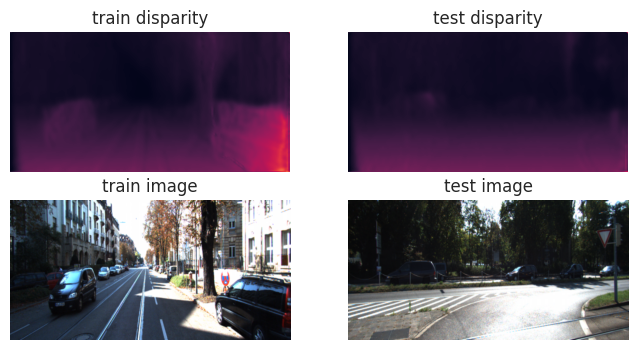

In [22]:
display_disparity_maps(depth_estimator_seg_model, single_image_loader, test_single_image_loader)

Due to usage limits, we limited our training runs to be ~1.5 hours on GPU (any longer and we usually got kicked off of Google Colab).

# Conclusions

We observe that the model architecture pursuant to (Godard, Aodha, Brostow, 2016), when trained starting from randomly initialized weights, can create detailed disparity maps. However, we find that training from a ResNet-50 greatly improves our performance compared to a randomly initialized network. This contrasts with the results from Godard et al. 2016, however this discrepancy is likely due to the fact that we train on a much smaller subset of the data (Their training used >30,000 images, we use 400). These choices were made largely due to the small compute budget and time constraints of this project.

We extended the work in Godard, Aodha, Brostow, 2016 using segmantic networks inspired by Toyota Research. These networks can provide the depth estimation network priors that give information about the relative size of objects that may be in a scene. The segmantic network significantly improves the resulting disparity maps.

We observed that the models typically struggled to accurately estimate disparities for reflective surfaces, like well-lit sections of a road or lane markers. We believe that mispredictions at boundaries of well-lit areas are not strongly penalized because these boundaries look like edges, allowing for depth discontinuity.

